# Topic:- DeepFake Detection

## Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## Load Training & Validation Data Using tf.data

In [2]:
train_set = tf.keras.utils.image_dataset_from_directory(
    'Data/Dataset/Train',
    validation_split=0.3,
    subset='training',
    seed=123,
    image_size=(224,224),
    batch_size=64,
    label_mode='binary'
)

Found 140002 files belonging to 2 classes.
Using 98002 files for training.


In [3]:
val_set = tf.keras.utils.image_dataset_from_directory(
    'Data/Dataset/Test',
    validation_split=0.3,
    subset='validation',
    seed=123,
    image_size=(224,224),
    batch_size=32,
    label_mode='binary'
)

Found 10907 files belonging to 2 classes.
Using 3272 files for validation.


### Class Name

In [20]:
class_names = train_set.class_names
print("Classes:", class_names)

AttributeError: '_TakeDataset' object has no attribute 'class_names'

In [5]:
train_set = train_set.take(int(len(train_set)))
val_set   = val_set.take(int(len(val_set)))
print("New train batches:", len(train_set))
print("New val batches:", len(val_set))

New train batches: 1532
New val batches: 103


### Reduce the size of data equally

In [6]:
# Reduce size equally (example: only 25% of data)
REDUCE_FACTOR = 0.25

train_set = train_set.take(int(len(train_set) * REDUCE_FACTOR))
val_set   = val_set.take(int(len(val_set) * REDUCE_FACTOR))

print("New train batches:", len(train_set))
print("New val batches:", len(val_set))

New train batches: 383
New val batches: 25


### View Sample Images of Training Data

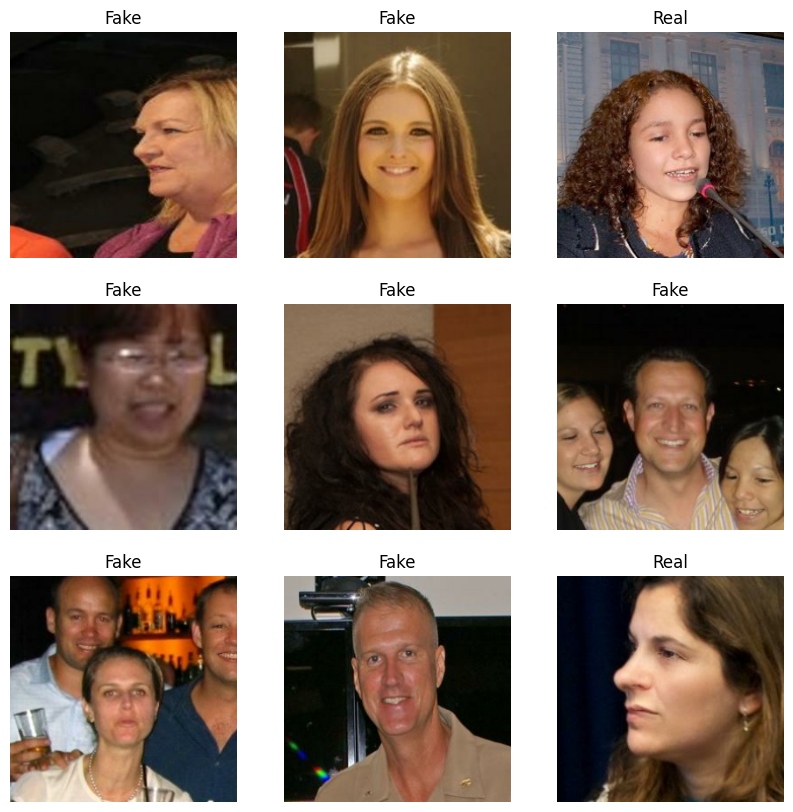

In [7]:
for images, labels in train_set.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Fake" if labels[i].numpy()==1 else "Real")
        plt.axis("off")
    plt.show()

### View Sample Images of Testing Data

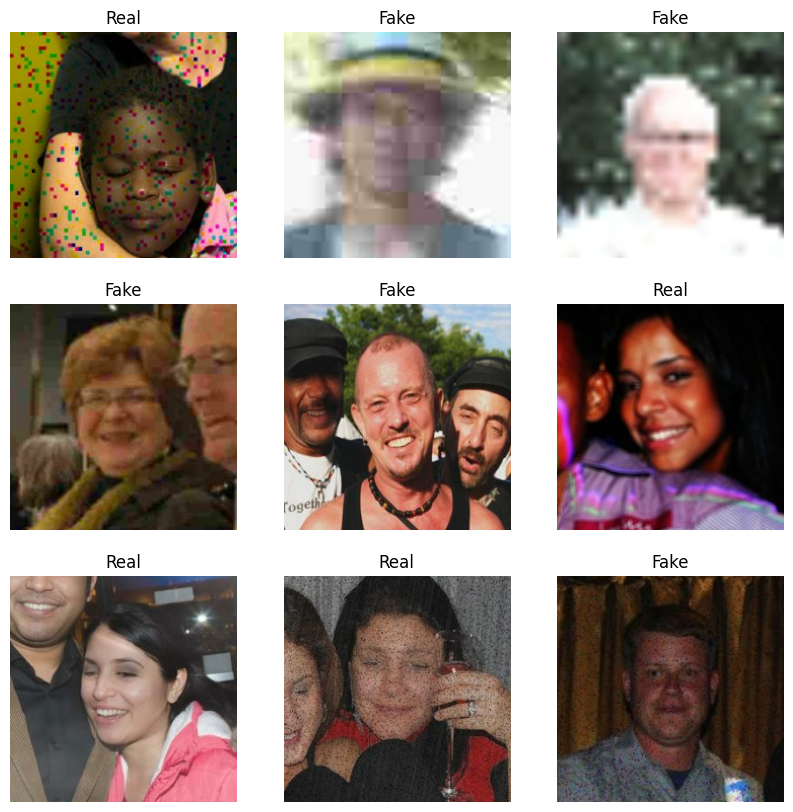

In [8]:
for images, labels in val_set.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Fake" if labels[i].numpy()==1 else "Real")
        plt.axis("off")
    plt.show()

## Model Building

In [9]:

def build_model(input_shape=(224,224,3), base_trainable=False):
    base = tf.keras.applications.EfficientNetB0(
        include_top=False, weights='imagenet', input_shape=input_shape
    )
    base.trainable = base_trainable

    inputs = layers.Input(shape=input_shape)
    x = tf.keras.applications.efficientnet.preprocess_input(inputs)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(524, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
# compile 
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

model = build_model()



## Summary of Model

In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 524)                 │         671,244 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 524)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             525 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,721,340 (18.01 MB)

 Trainable params: 671,769 (2.56 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [11]:
callbacks = [
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_auc', mode='max'),
    EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
]
# Train the model
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=7,
    callbacks=callbacks
)

Epoch 1/7
383/383 ━━━━━━━━━━━━━━━━━━━━ 467s 1s/step - accuracy: 0.7276 - auc: 0.8030 - loss: 0.5395 - val_accuracy: 0.6988 - val_auc: 0.8061 - val_loss: 0.5623 - learning_rate: 1.0000e-04
Epoch 2/7
383/383 ━━━━━━━━━━━━━━━━━━━━ 482s 1s/step - accuracy: 0.7637 - auc: 0.8448 - loss: 0.4863 - val_accuracy: 0.7000 - val_auc: 0.8098 - val_loss: 0.5817 - learning_rate: 1.0000e-04
Epoch 3/7
383/383 ━━━━━━━━━━━━━━━━━━━━ 561s 1s/step - accuracy: 0.7742 - auc: 0.8570 - loss: 0.4687 - val_accuracy: 0.7038 - val_auc: 0.8040 - val_loss: 0.5867 - learning_rate: 1.0000e-04
Epoch 4/7
383/383 ━━━━━━━━━━━━━━━━━━━━ 464s 1s/step - accuracy: 0.7791 - auc: 0.8620 - loss: 0.4606 - val_accuracy: 0.7013 - val_auc: 0.8106 - val_loss: 0.6021 - learning_rate: 1.0000e-04
Epoch 5/7
383/383 ━━━━━━━━━━━━━━━━━━━━ 450s 1s/step - accuracy: 0.7821 - auc: 0.8669 - loss: 0.4529 - val_accuracy: 0.7212 - val_auc: 0.8130 - val_loss: 0.5796 - learning_rate: 5.0000e-05
Epoch 6/7
383/383 ━━━━━━━━━━━━━━━━━━━━ 450s 1s/step - accura

### Save the model

In [12]:
model.save("final_model.keras")
print("Training Completed!")

Training Completed!


### Train the model

## Accuracy & Loss & AUC(Area Under the ROC Curve)

In [13]:
train_loss, train_acc, train_auc = model.evaluate(train_set)

print("Train Loss:", train_loss)
print("Train Accuracy:", train_acc)
print("Train AUC:", train_auc)

383/383 ━━━━━━━━━━━━━━━━━━━━ 459s 1s/step - accuracy: 0.8216 - auc: 0.9041 - loss: 0.3995
Train Loss: 0.3994583785533905
Train Accuracy: 0.821556806564331
Train AUC: 0.9040849208831787


### Training Accuracy/Loss Plots

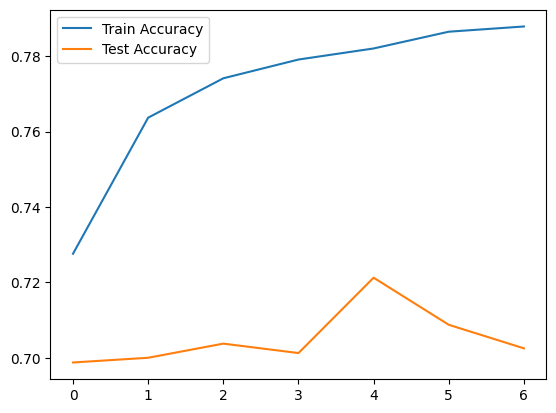

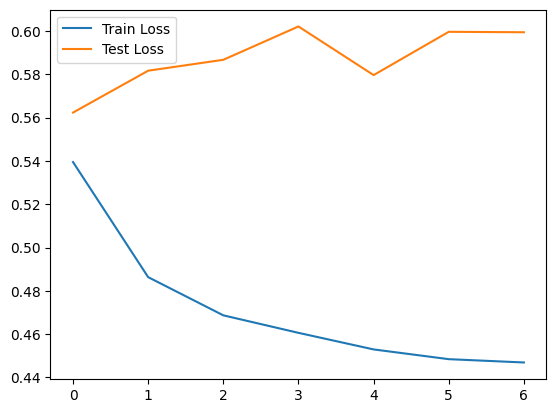

In [14]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.show()

### Prediction on one image

In [15]:
from PIL import Image
import numpy  as np
MODEL_PATH = "final_model.keras"   # or best_model.h5
IMG_SIZE = (224, 224)

# Load model
model = tf.keras.models.load_model(MODEL_PATH)
print("Model Loaded Successfully!")

def predict_image(img_path):
    # Load and preprocess image
    img = Image.open(img_path).convert("RGB")
    img = img.resize(IMG_SIZE)
    
    arr = np.array(img)
    arr = tf.keras.applications.efficientnet.preprocess_input(arr)
    arr = np.expand_dims(arr, axis=0)   # (1,224,224,3)
    
    # Predict
    pred = model.predict(arr)[0][0]
    
    label = "FAKE" if pred >= 0.5 else "REAL"
    confidence = float(pred if pred >= 0.5 else 1 - pred)

    print(f"Prediction: {label}  |  Confidence: {confidence:.4f}")
    return label, confidence

# Example:
predict_image("Data/Dataset/Test/Real/real_0.jpg")


Model Loaded Successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction: REAL  |  Confidence: 0.7905


('REAL', 0.7905418872833252)

## Confusion Matrix

In [16]:
# Collect all images and labels from val_ds
y_true = []
y_pred = []

for images, labels in val_set:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 692ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 698ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 712ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


In [17]:
print(classification_report(y_true, y_pred, target_names=class_names))

NameError: name 'class_names' is not defined

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Output Folder

In [ ]:
# Create output folder 
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def show_predictions(n=9):
    plt.figure(figsize=(9,9))
    i = 0
    for images, labels in val_set.take(1):
        preds = model.predict(images)
        for j in range(images.shape[0]):
            if i >= n: break
            ax = plt.subplot(3,3,i+1)

            img = images[j].numpy()
            img = (img - img.min())/(img.max() - img.min())
            plt.imshow(img)

            true = class_names[int(labels[j])]
            pred = class_names[int(np.argmax(preds[j]))]

            plt.title(f"T:{true}\nP:{pred}")
            plt.axis('off')
            i += 1

    plt.suptitle("Sample predictions")

    # save image
    plt.savefig(os.path.join(OUTPUT_DIR, "pred_examples.png"))
    plt.show()

show_predictions()
